Estimator API

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow==2.0.0

import tensorflow as tf
import pandas as pd

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

Load the Titanic dataset

In [0]:
import tensorflow.compat.v2.feature_column as fc

In [0]:
# Load the dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

Explore the dataset

In [6]:
tf.random.set_seed(123)
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [0]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [0]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

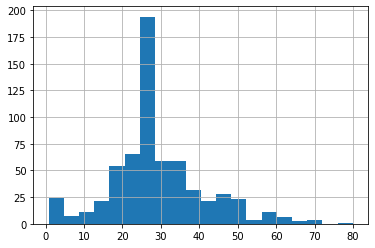

In [0]:
dftrain.age.hist(bins=20)

Sex plot

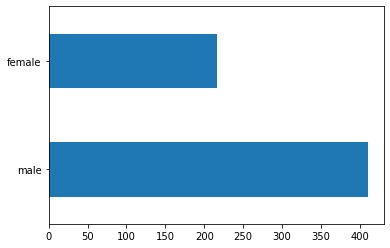

In [0]:
dftrain.sex.value_counts().plot(kind='barh')

Inspect data

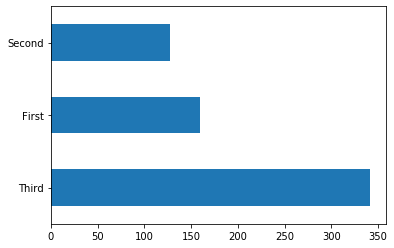

In [0]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

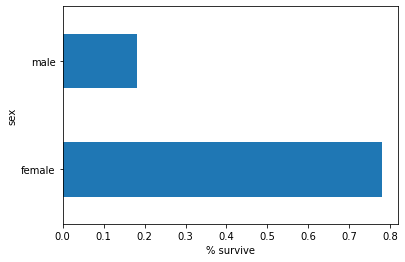

In [0]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

Feature Engineering for the model

Base Feature Coulmns

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [23]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class',('First','Second','Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [41]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

Input Function

In [0]:
# Use entire batch since this is such as small dataset
NUM_EXAMPLE = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))

    # Shuffle and repeat for training
    if shuffle:
      dataset = dataset.shuffle(1000)
    
    # Fron training, cycle through dataset as many times as possible
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching
    dataset = dataset.batch(NUM_EXAMPLE)
    return dataset
  return input_fn

# Training and Evaluation input Functions
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, shuffle=False)

Inspect the dataset

In [43]:
ds = make_input_fn(dftrain, y_train)()
for feature_batch, label_batch in ds.take(1):
  print('Some Feature Keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', list(feature_batch['class'].numpy()))
  print()
  print('A batch of labels:', list(label_batch.numpy()))
  print()

Some Feature Keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second', b'First', b'First', b'Third', b'First', b'Third', b'Second', b'First', b'First', b'Third', b'Third', b'Third', b'Third', b'Third', b'Third', b'Third', b'Third', b'Third', b'First', b'Second', b'Third', b'Second', b'Third', b'Second', b'Third', b'Third', b'Third', b'First', b'Second', b'Second', b'First', b'Third', b'First', b'First', b'Third', b'Third', b'First', b'Third', b'First', b'Third', b'Third', b'Third', b'First', b'Third', b'First', b'Second', b'Third', b'Third', b'Third', b'Third', b'Second', b'First', b'Third', b'Second', b'Second', b'Third', b'First', b'Third', b'First', b'Second', b'Third', b'Third', b'Third', b'Third', b'Second', b'First', b'Third', b'First', b'Third', b'Third', b'First', b'First', b'First', b'Third', b'Second', b'Second', b'Third', b'First', b'First', b'Third', b'Third', b'Third', b'Second', b'First', b'Second',

You can also inspect the result of a specific feature columns using the tf.keras.layers.DenseFeatures layer

In [44]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[23.  ],
       [35.  ],
       [40.  ],
       [28.  ],
       [28.  ],
       [28.  ],
       [62.  ],
       [49.  ],
       [48.  ],
       [23.  ],
       [28.  ],
       [28.  ],
       [21.  ],
       [28.  ],
       [21.  ],
       [ 9.  ],
       [28.  ],
       [28.  ],
       [60.  ],
       [34.  ],
       [28.  ],
       [29.  ],
       [30.  ],
       [47.  ],
       [10.  ],
       [29.  ],
       [30.  ],
       [38.  ],
       [23.  ],
       [36.  ],
       [28.  ],
       [28.  ],
       [24.  ],
       [45.  ],
       [ 9.  ],
       [28.  ],
       [63.  ],
       [ 7.  ],
       [71.  ],
       [21.  ],
       [20.  ],
       [45.  ],
       [24.  ],
       [16.  ],
       [26.  ],
       [18.  ],
       [19.  ],
       [19.  ],
       [28.  ],
       [36.  ],
       [22.  ],
       [38.  ],
       [22.  ],
       [38.  ],
       [29.  ],
       [24.  ],
       [14.  ],
       [41.  ],
       [28.  ],
       [30.  ],
       [20.  ],
       [28.  ],
       [

DenseFeature only accepts dense tensor, to inspect a categorical column you need to transform that to a indicator first:

After adding all the base_features to model, let's train model

In [51]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model
linear_est.train(train_input_fn, max_steps=100)

# Evaluation
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


Train, Evaluate and Predict

Let's build Boosted Tree Model

In [52]:
# Since data fits into memory, use entire dataset per layer, It will be faster
# Above one batch is defined as the entire dataset
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not based on number of steps
est.train(train_input_fn, max_steps=100)

#Eval
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.818182
accuracy_baseline         0.625000
auc                       0.859933
auc_precision_recall      0.850304
average_loss              0.419193
label/mean                0.375000
loss                      0.419193
precision                 0.774194
prediction/mean           0.379677
recall                    0.727273
global_step             100.000000
dtype: float64


Making Predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_u1f09ef/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


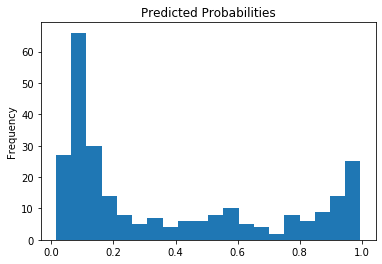

In [53]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='Predicted Probabilities')

ROC Curve

(0, 1.05)

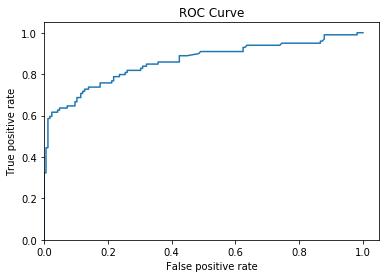

In [54]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval,  probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,)
plt.ylim(0,)

Conclusion